<a href="https://colab.research.google.com/github/saspav/python_for_pro/blob/main/%D0%90%D1%82%D1%82%D0%B5%D1%81%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%A2%D1%80%D0%B5%D1%82%D0%B8%D0%B9_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B8%D0%BB%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='green' size='7'>**Промежуточная аттестация 2**</font>  
<font color='#11a642' size='6'>**Тема: Временные ряды**</font>  
<font size='5'>**Задание:**</font>  

Домашняя работа основана на лекции и семинаре по Временным рядам.

Данные для домашнего задания прикреплены в Дополнительных материалах.





**Описание плана работы**

1. Загрузка данных. Убедиться, что дата является индексом датасета.
2. Провести разведочный анализ данных (EDA).
3. Провести тест на стационарность ряда. Сделать вывод о стационарности.
4. Разделить данные на тестовую и тренировочную выборку.
5. Автоматически подобрать параметры для ряда с помощью auto_arima. Выбрать оптимальные значения.
7. Построить и обучить модель ARIMA, используя p,d,q из полученного результата по auto_arima. Построить прогноз для тестового набора данных. Оценить модель ARIMA.
8. Разложить на тренд и сезонность с помощью prophet. Оценить модель prophet
9. Сравнить модель ARIMA и prophet. Выбрать лучшую


# <font color='#11a642' size='6'> Импорт и установка библиотек



In [ ]:
# установка дополнительной библиотеки
# !pip install pmdarima

In [ ]:
import random
import numpy as np # математические вычисления
import pandas as pd # работа с таблицами
import matplotlib
import matplotlib.pyplot as plt # визуализация данных

from scipy import stats # статистические методы
from statsmodels.tsa.stattools import adfuller # тест Дики-Фуллера
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima # автоматический подбор параметров
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from sklearn.metrics import (  # Метрики оценки качества модели
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

# Настройки отображения данных в Pandas
pd.set_option('display.max_columns', 50)  # Отображать до 50 столбцов
pd.set_option('display.precision', 5)  # Отображение ДФ с 5-ю знаками после запятой

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)

In [ ]:
# Зафиксируем сиды

SEED = 127
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
# Переиспользуем все функции с прошлых ноутбуков

def rmsle(y_true, y_pred):
    """
    Расчет метрики Root Mean Squared Logarithmic Error
    :param y_true: y_true
    :param y_pred: y_pred
    :return: RMSLE
    """
    y_true = np.array(y_true)
    y_pred = np.maximum(0, np.array(y_pred))
    return np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred)) ** 2))


def get_metrics(y_true, y_pred):
    """
    Расчет метрики Root Mean Squared Logarithmic Error
    :param y_true: y_true
    :param y_pred: y_pred
    :return: метрики
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmsle_ = rmsle(y_true, y_pred)
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2, 'rmsle': rmsle_}

# <font color='#11a642' size='6'> Загрузка данных


In [ ]:
try:
    df = pd.read_csv('Electric_Production.csv')
except:
    df = pd.read_csv('https://drive.google.com/uc?id=1XFoZrWweyXM4kO9JWitNyAp50yySiMx_')

In [ ]:
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


# <font color='#11a642' size='6'> Провести разведочный анализ данных (EDA)

- Анализ пропусков и выбросов


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [ ]:
# Дата в текством формате, преобразуем её в дату

df['DATE'] = pd.to_datetime(df['DATE'], format="%m/%d/%Y", errors='coerce')

In [ ]:
# Пропуски по всем столбцам (пропусков нет)
print(df.isnull().sum())

DATE          0
IPG2211A2N    0
dtype: int64


In [ ]:
# Cортировка по date и сброс индекса
df = df.sort_values("DATE").reset_index(drop=True)
df

,DATE,IPG2211A2N
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151
...,...,...
392,2017-09-01,98.6154
393,2017-10-01,93.6137
394,2017-11-01,97.3359
395,2017-12-01,114.7212


In [ ]:
# Проверка на пропуски в календарной сетке
expected = pd.date_range(start=df["DATE"].min(), end=df["DATE"].max(), freq="MS")  # MS = Month Start
missing = expected.difference(df["DATE"])

print(f"Пропущено месяцев: {len(missing)}")
if not missing.empty:
    print("Пропущенные месяцы:\n", missing)

Пропущено месяцев: 0


#### Явных пропусков нет, также нет пропусков во временном ряде, т.е. мы имеем непрерывный временной ряд с шагом 1 месяц

In [ ]:
# Поиск выбросов в IPG2211A2N

Q1 = df["IPG2211A2N"].quantile(0.25)
Q3 = df["IPG2211A2N"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = df[(df["IPG2211A2N"] < lower) | (df["IPG2211A2N"] > upper)]

print("Найдено выбросов:", len(outliers))

Найдено выбросов: 0


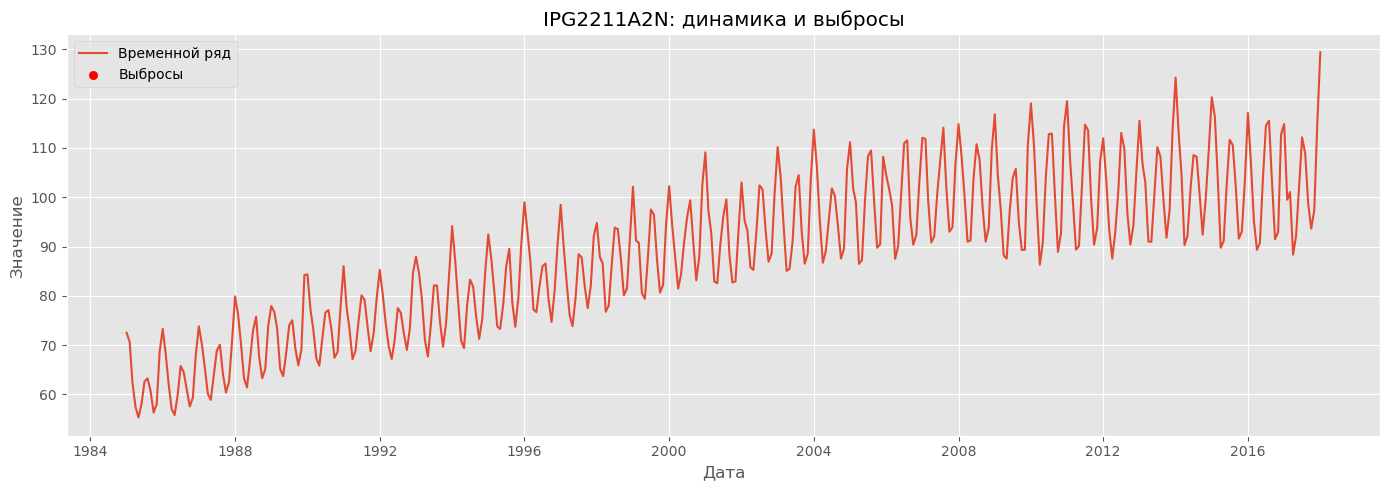

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(df["DATE"], df["IPG2211A2N"], label="Временной ряд")
plt.scatter(outliers["DATE"], outliers["IPG2211A2N"], color="red", label="Выбросы")
plt.title("IPG2211A2N: динамика и выбросы")
plt.xlabel("Дата")
plt.ylabel("Значение")
plt.legend()
plt.tight_layout()
plt.show()

# <font color='#11a642' size='6'> Провести анализ временного ряда

## <font color='#11a642' size='5'>Автокорреляция

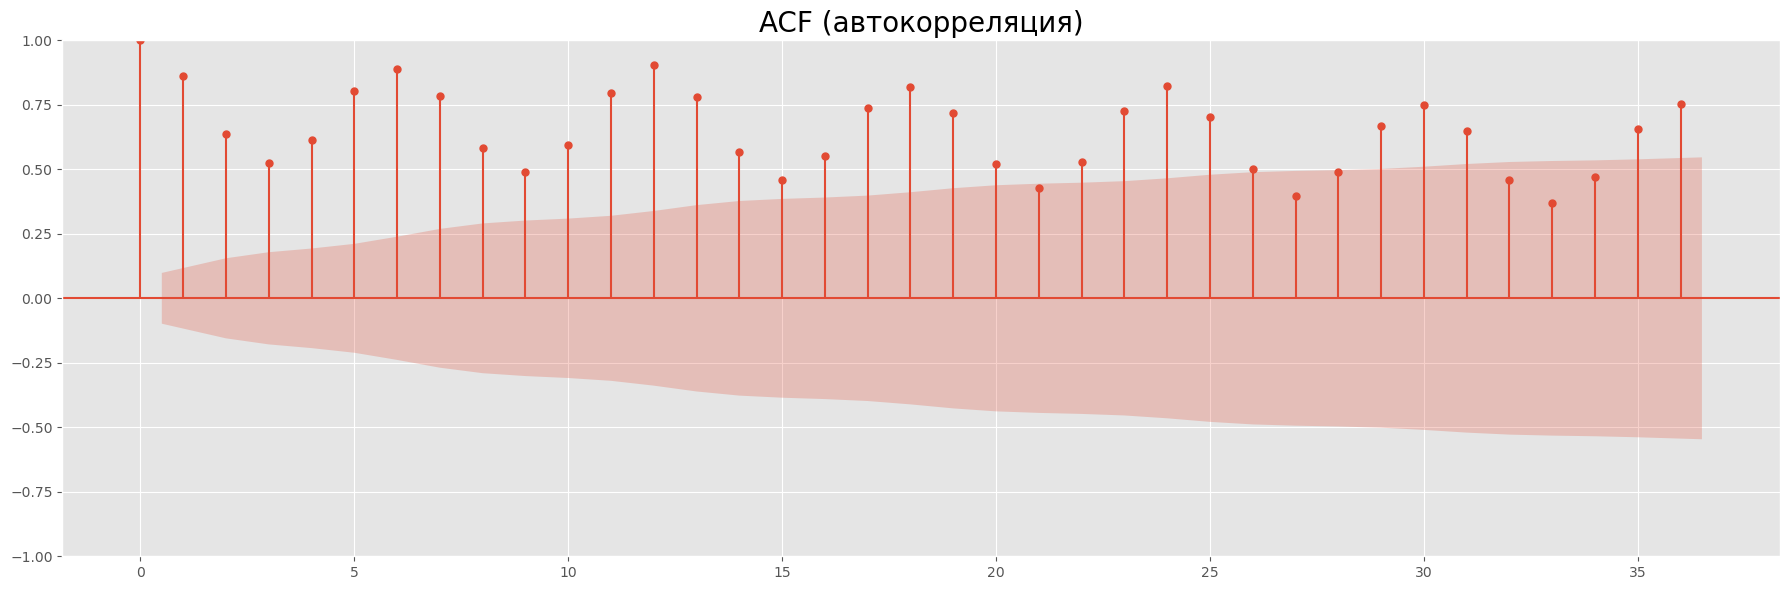

In [ ]:
# ACF
plt.figure(figsize=(18, 6))
plot_acf(df["IPG2211A2N"], lags=36, ax=plt.gca()) # возьмем лаг в 3 года
plt.title("ACF (автокорреляция)", fontsize=20)
plt.tight_layout()
plt.show()

На графике показана **функция автокорреляции (ACF)** для временного ряда `IPG2211A2N` с лагами до 36 месяцев (3 года).
---
## 📊 **Анализ ACF-графика:**

### 🔹 1. **Сильная положительная автокорреляция**

* Значения автокорреляции на многих лагах (1–36) значительно выше 0 и выходят за пределы доверительного интервала (голубая зона).
* Это означает, что ряд имеет **долгосрочную зависимость**: текущее значение сильно зависит от предыдущих.

### 🔹 2. **Признак сезонности**

* Обратите внимание на **волнообразный характер** ACF: пики идут примерно каждые **12 месяцев**.
* Это типично для **годовой сезонности**, особенно в промышленности или экономических показателях.

  ➤ Примеры заметных пиков на лагах ≈ 12, 24, 36 — подтверждают **12-месячную сезонность**.

### 🔹 3. **Нестационарность**

* ACF **медленно убывает**, не стремится к нулю быстро.
* Это указывает на **тренд** или **нестационарность** ряда.

  ➤ Для модели ARIMA это значит: нужно дифференцирование (`d=1`), чтобы устранить тренд.

---

## ✅ Вывод:

| Признак                | Интерпретация                          |
| ---------------------- | -------------------------------------- |
| Высокие лаги           | Ряд обладает длительной памятью        |
| Медленное затухание    | Присутствует тренд → ряд нестационарен |
| Периодичность ≈ 12 мес | Вероятная годовая сезонность           |

## <font color='#11a642' size='5'>Частичная автокорреляция

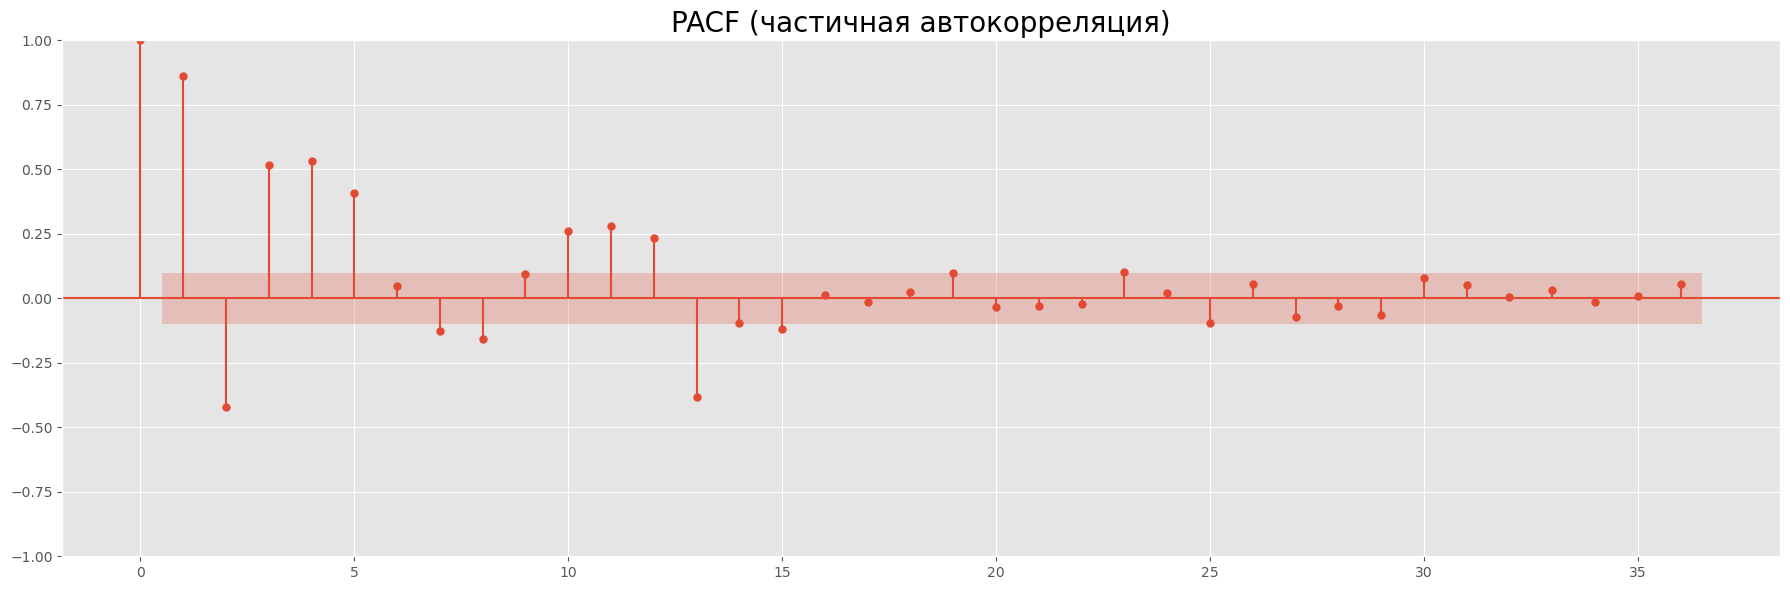

In [ ]:
# PACF
plt.figure(figsize=(18, 6))
plot_pacf(df["IPG2211A2N"], lags=36, ax=plt.gca()) # возьмем лаг в 3 года
plt.title("PACF (частичная автокорреляция)", fontsize=20)
plt.tight_layout()
plt.show()

**PACF-график (частичная автокорреляция)**. Он помогает определить, какие **лаги напрямую влияют** на текущее значение, устраняя влияние промежуточных лагов.
---
## 📊 Что видно на PACF-графике:

### 🔹 1. **Значимые лаги:**

* **Лаги 1, 2, 3, 4 и 5** заметно выходят за пределы доверительного интервала.
* Это говорит о том, что текущие значения ряда сильно зависят от 1–5 предыдущих значений (то есть, присутствует **авторегрессия порядка 5** → AR(5)).

---

### 🔹 2. **Дальнейшие лаги слабы:**

* После лага 5 значения автокорреляций приближаются к нулю и находятся **в пределах доверительного интервала**, значит их влияние несущественно.

---

### 🔹 3. **Отдельные всплески на лагах 11–13**

* Есть слабые локальные выбросы — могут намекать на **сезонность \~12 месяцев**, но они уже значительно ниже основных.
* В отличие от ACF-графика, сезонность в PACF может быть **неярко выраженной**.

---

## 📌 Вывод:

| Признак             | Интерпретация                    |
| ------------------- | -------------------------------- |
| Лаги 1–5 значимы    | Хорошо описываются AR(5)-моделью |
| Лаги > 6 ≈ 0        | Их влияние можно отбросить       |
| Периодичность ≈ 12? | Слабое подтверждение сезонности  |

# <font color='#11a642' size='6'> Провести тест на стационарность ряда

In [ ]:
def adf_test(series, title=''):
    '''
    тест Дики-Фуллера
    0 гипотеза: ряд данных не стационарен
    альтернативная гипотеза: ряд данных стационарен
    Понятие стационарного временного ряда означает, что его среднее значение не изменяется во времени,
    т. е. временной ряд не имеет тренда
    @param series - значения ряда
    @param title - заголовок ряда
    '''

    result = adfuller(series.dropna(),autolag='AIC')

    labels = ['ADF тест','p-value','# lags used','# наблюдения']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'критическое значение ({key})']=val

    print(out.to_string())

    if result[1] <= 0.05:
        print("Сильные доказательства против нулевой гипотезы")
        print("Отменяем 0 гипотезу")
        print("Данные стационарны")
    else:
        print("Слабые доказательства против нулевой гипотезы")
        print("Не отменяем 0 гипотезу")
        print("Данные не стационарны")

In [ ]:
adf_test(df['IPG2211A2N'])

ADF тест                       -2.25699
p-value                         0.18621
# lags used                    15.00000
# наблюдения                  381.00000
критическое значение (1%)      -3.44763
критическое значение (5%)      -2.86916
критическое значение (10%)     -2.57083
Слабые доказательства против нулевой гипотезы
Не отменяем 0 гипотезу
Данные не стационарны


### Сделать вывод о стационарности:

### Тест Дики-Фуллера (ADF) показал, что исходный ряд IPG2211A2N нестационарен:

    p-value = 0.18621 > 0.05 → нулевая гипотеза не отвергается

    Следовательно, ряд имеет тренд и/или сезонность, и требует преобразования.

In [ ]:
# Приведение ряда к стационарности

# Разностное преобразование (1-я разность)
df["IPG2211A2N_diff1"] = df["IPG2211A2N"].diff()

adf_test(df["IPG2211A2N_diff1"], title="Первая разность")

ADF тест                     -7.10489e+00
p-value                       4.07779e-10
# lags used                   1.40000e+01
# наблюдения                  3.81000e+02
критическое значение (1%)    -3.44763e+00
критическое значение (5%)    -2.86916e+00
критическое значение (10%)   -2.57083e+00
Сильные доказательства против нулевой гипотезы
Отменяем 0 гипотезу
Данные стационарны


Отлично! 🎯

Тест Дики-Фуллера после разностного преобразования дал такие результаты:

---

## ✅ Результат теста ADF после первой разности:

| Метрика                       | Значение                    |
| ----------------------------- | --------------------------- |
| **ADF-статистика**            | -7.10                       |
| **p-value**                   | 4.08e-10 (≈ 0.0000000004)   |
| **Критические значения (5%)** | -2.86916                    |
| **Вывод**                     | ❗ **Ряд стал стационарным** |

---

### 🔍 Интерпретация:

* Поскольку `p-value << 0.05`, нулевая гипотеза отвергается.
* Статистика ADF сильно меньше всех критических значений → это **уверенное подтверждение стационарности**.
* Значит, **тренд устранён** и ряд можно использовать для моделирования (например, ARIMA или SARIMA).


# <font color='#11a642' size='6'> Разделить данные на тестовую и тренировочную выборку

In [ ]:
df = df.set_index("DATE")

# делим на 90% обучение, 10% тест

# Кол-во наблюдений
n_total = len(df)
n_test = int(n_total * 0.1)  # 10% на тест
n_train = n_total - n_test   # остальные — обучение

# Разделение
train = df.iloc[:n_train].copy()
test = df.iloc[n_train:].copy()

print(f"Размер train: {train.shape}")
print(f"Размер test : {test.shape}")
print(f"Последняя дата train: {train.index.max().date()}")
print(f"Первая дата test    : {test.index.min().date()}")

Размер train: (358, 2)
Размер test : (39, 2)
Последняя дата train: 2014-10-01
Первая дата test    : 2014-11-01


# <font color='#11a642' size='6'> Модель SARIMA
Автоматически подобрать параметры для ряда с помощью auto_arima. Выбрать оптимальные значения

In [ ]:
# Запуск auto_arima
model = auto_arima(
    train["IPG2211A2N"],
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    seasonal=True,
    m=12,  # сезонность = 12 месяцев
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    d=1,  # 1-я разность (мы её проверили)
    D=1,  # сезонная разность
    trace=True,       # показывать лог подбора
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True     # быстрый перебор (рекомендуется)
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1745.202, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1687.408, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1601.732, Time=0.12 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1718.055, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1602.484, Time=0.16 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1601.706, Time=0.34 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1601.373, Time=0.55 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=1588.147, Time=0.80 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1593.536, Time=0.35 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=1614.408, Time=0.67 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=1543.156, Time=1.20 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=1551.241, Time=0.80 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=1544.660, Time=0.74 sec
 ARIMA(1,1,1)(1,1,1)[12]

In [ ]:
# ✅ Лучшие параметры модели:

print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  358
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -764.254
Date:                            Thu, 03 Jul 2025   AIC                           1542.508
Time:                                    21:50:54   BIC                           1569.412
Sample:                                01-01-1985   HQIC                          1553.222
                                     - 10-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0037      0.001     -2.824      0.005      -0.006      -0.001
ar.L1          0.5403      0.051   

### Ваш вывод (сравнить значения параметров):
---

Получилось подобрать и оценить модель **SARIMA(1,1,1)(2,1,1)\[12]** с помощью `auto_arima`.
---

## 🔧 **Выбранная модель:**

**SARIMA(p=1, d=1, q=1)(P=2, D=1, Q=1, s=12)** с `intercept`

| Компонент     | Значение                                 | Обозначение                           |
| ------------- | ---------------------------------------- | ------------------------------------- |
| **p=1**       | AR(1)                                    | Зависимость от предыдущего значения   |
| **d=1**       | 1-я разность (устраняет тренд)           |                                       |
| **q=1**       | MA(1)                                    | Учитывает ошибки предыдущего прогноза |
| **P=2**       | Сезонная AR (двухгодовая память)         |                                       |
| **D=1**       | Сезонная разность (устраняет сезонность) |                                       |
| **Q=1**       | Сезонная MA (сглаживание сезонных шумов) |                                       |
| **s=12**      | Период сезонности — 12 месяцев (год)     |                                       |
| **intercept** | Есть (значим)                            |                                       |

---

## 📈 **Коэффициенты и их значимость**

| Параметр            | Значение | P-значение | Вывод                    |
| ------------------- | -------- | ---------- | ------------------------ |
| **intercept**       | -0.0037  | 0.005      | Значим 🟢                |
| **AR(1)**           | 0.5403   | 0.000      | Значим 🟢                |
| **MA(1)**           | -0.9759  | 0.000      | Значим 🟢                |
| **SAR(1) (lag=12)** | -0.0230  | 0.776      | Не значим 🔴             |
| **SAR(2) (lag=24)** | -0.2131  | 0.002      | Значим 🟢                |
| **SMA(1) (lag=12)** | -0.6552  | 0.000      | Значим 🟢                |
| **sigma² (ошибки)** | 4.7243   | 0.000      | Статистически обосновано |

—

## 🔍 Диагностика модели

| Метрика              | Значение                          | Комментарий            |
| -------------------- | --------------------------------- | ---------------------- |
| **AIC**              | 1542.508                          | Чем меньше — тем лучше |
| **BIC**              | 1569.412                          | Для сравнения моделей  |
| **Ljung-Box Q (L1)** | 0.34                              | Остатки ≈ белый шум ✅  |
| **JB test (p=0.00)** | есть асимметрия/не-нормальность ❗ |                        |
| **Skew/Kurtosis**    | умеренные                         | в пределах допустимого |

—

## ✅ **Вывод:**

Модель:

* **успешно устраняет тренд и сезонность**,
* имеет **адекватные параметры**, большинство из которых статистически значимы,
* даёт **низкий AIC**, что указывает на хорошее соответствие данным.

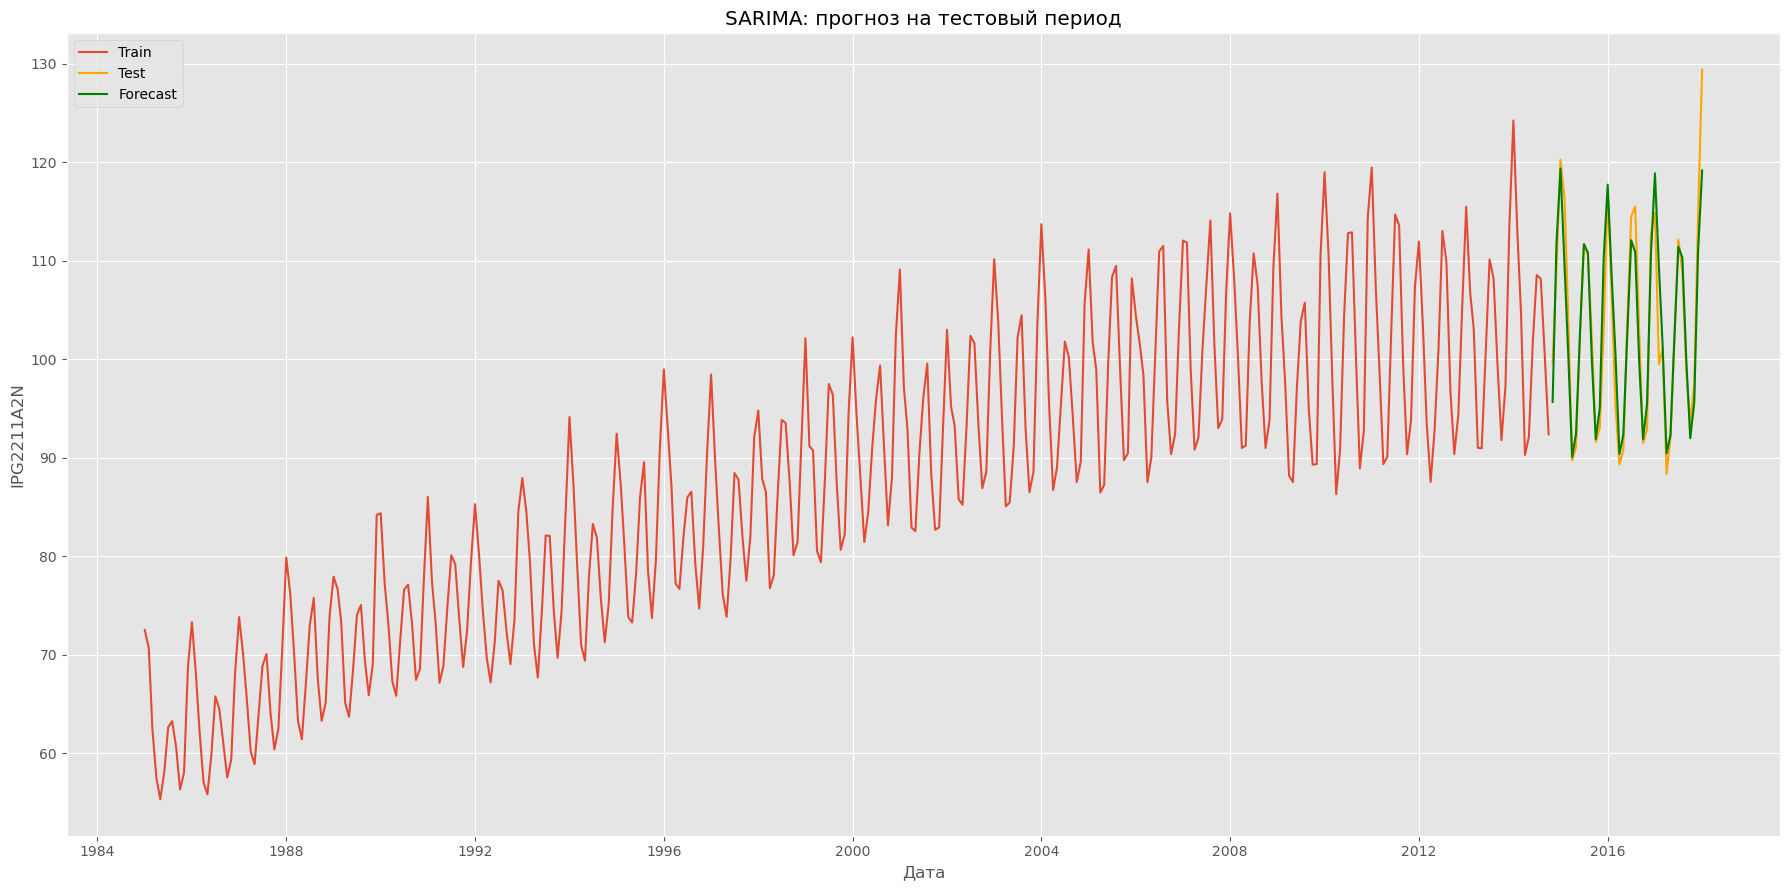

In [ ]:
# получение предсказаний
forecast = model.predict(n_periods=len(test))

# Преобразуем в DataFrame
forecast_df = pd.DataFrame({
    "DATE": test.index,
    "Forecast": forecast
})

# отрисовка обучающей выборки, тестовой и предсказанной тестовой
plt.figure(figsize=(18, 9))
plt.plot(train.index, train["IPG2211A2N"], label="Train")
plt.plot(test.index, test["IPG2211A2N"], label="Test", color="orange")
plt.plot(forecast_df.index, forecast_df["Forecast"], label="Forecast", color="green")
plt.title("SARIMA: прогноз на тестовый период")
plt.xlabel("Дата")
plt.ylabel("IPG2211A2N")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

График выглядит хорошо 📈 — видно:

* Красная линия — **обучающая выборка** (train).
* Оранжевая — **реальные значения на тесте** (test).
* Зелёная — **прогноз модели SARIMA** (forecast).

---

## 🧠 Что можно сказать о результате?

### ✅ **1. Общая форма прогноза адекватна**

SARIMA улавливает сезонность и общий уровень — поведение прогноза похоже на правду: повторяющиеся циклы и увеличение амплитуды.

---

### ⚠️ **2. Прогноз чуть запаздывает**

На глаз видно, что **зелёная кривая немного отстаёт** от реальных значений (оранжевых). Это типично для моделей ARIMA, особенно если сезонность выражена несимметрично.

> Это значит, что можно попробовать улучшить модель:
>
> * увеличить `P`, `Q`.
---

In [ ]:
# Повторный подбор модели с расширенным диапазоном сезонных параметров
model_improved = auto_arima(
    train["IPG2211A2N"],
    start_p=1, start_q=1,
    max_p=3, max_q=3,
    seasonal=True,
    m=12,  # сезонность — 12 месяцев
    start_P=1, start_Q=1,
    max_P=3, max_Q=3,  # увеличили P и Q
    d=1,
    D=1,
    stepwise=True,
    trace=True,
    error_action="ignore",
    suppress_warnings=True
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1552.996, Time=0.77 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1745.202, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1687.408, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1601.732, Time=0.33 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1552.145, Time=0.64 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1552.284, Time=1.43 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1621.310, Time=0.55 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=1551.241, Time=1.98 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=1543.156, Time=3.28 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=1544.660, Time=1.56 sec
 ARIMA(1,1,1)(3,1,2)[12]             : AIC=1545.102, Time=22.13 sec
 ARIMA(1,1,1)(2,1,3)[12]             : AIC=1545.073, Time=17.71 sec
 ARIMA(1,1,1)(1,1,3)[12]             : AIC=1543.506, Time=15.52 sec
 ARIMA(1,1,1)(3,1,1)[

In [ ]:
# 📈 Посмотрим, стала ли модель лучше
print(model_improved.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  358
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -764.254
Date:                            Thu, 03 Jul 2025   AIC                           1542.508
Time:                                    21:55:10   BIC                           1569.412
Sample:                                01-01-1985   HQIC                          1553.222
                                     - 10-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0037      0.001     -2.824      0.005      -0.006      -0.001
ar.L1          0.5403      0.051   

Получили тот же результат, что и **до улучшения** — модель **SARIMA(1,1,1)(2,1,1)\[12]** с **AIC = 1542.508**, который уже был ранее. Значит, при увеличении `max_P` и `max_Q` до 3, `auto_arima` **всё равно выбрал прежнюю модель как лучшую**.
---

## 📌 Вывод:

🔹 **Модель SARIMA(1,1,1)(2,1,1)\[12]** остаётся оптимальной по AIC среди всех проверенных, даже при расширенном поиске.

In [ ]:
# Посчитаем метрики

metrics_sarima = get_metrics(test["IPG2211A2N"], forecast_df["Forecast"])

# Создаем DataFrame
metrics_sarima = pd.DataFrame({'Metric': list(metrics_sarima.keys()),
                               'SARIMA': list(metrics_sarima.values())})
metrics_sarima

,Metric,SARIMA
0,mse,12.13370
1,rmse,3.48335
2,mae,2.46306
3,mape,0.02331
4,r2,0.88222
5,rmsle,0.03178


# <font color='#11a642' size='6'> Модель PROPHET

In [ ]:
# Переименуем столбцы под формат Prophet
train_prophet = train.reset_index()[["DATE", "IPG2211A2N"]].rename(columns={
    "DATE": "ds",
    "IPG2211A2N": "y"
})

test_prophet = test.reset_index()[["DATE", "IPG2211A2N"]].rename(columns={
    "DATE": "ds",
    "IPG2211A2N": "y"
})

# Обучение модели
model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)
model_prophet.fit(train_prophet)

21:55:10 - cmdstanpy - INFO - Chain [1] start processing
21:55:10 - cmdstanpy - INFO - Chain [1] done processing


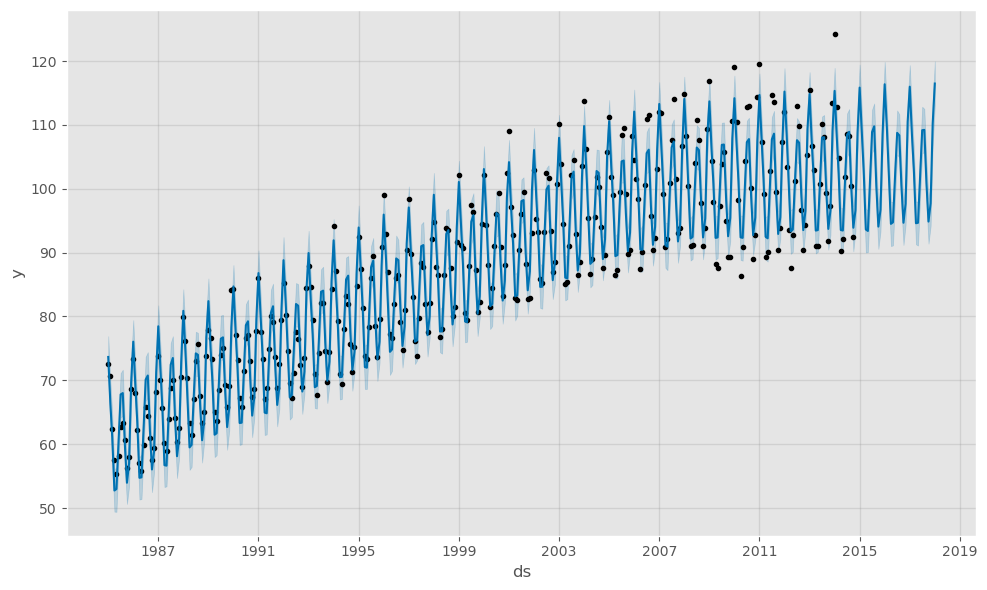

In [ ]:
# Кол-во точек в тестовой выборке
n_periods = len(test)

# Создаём датафрейм с будущими датами
future = model_prophet.make_future_dataframe(periods=n_periods, freq='MS')  # MS = месяц начала

# Прогноз
forecast = model_prophet.predict(future)

ax = model_prophet.plot(forecast)

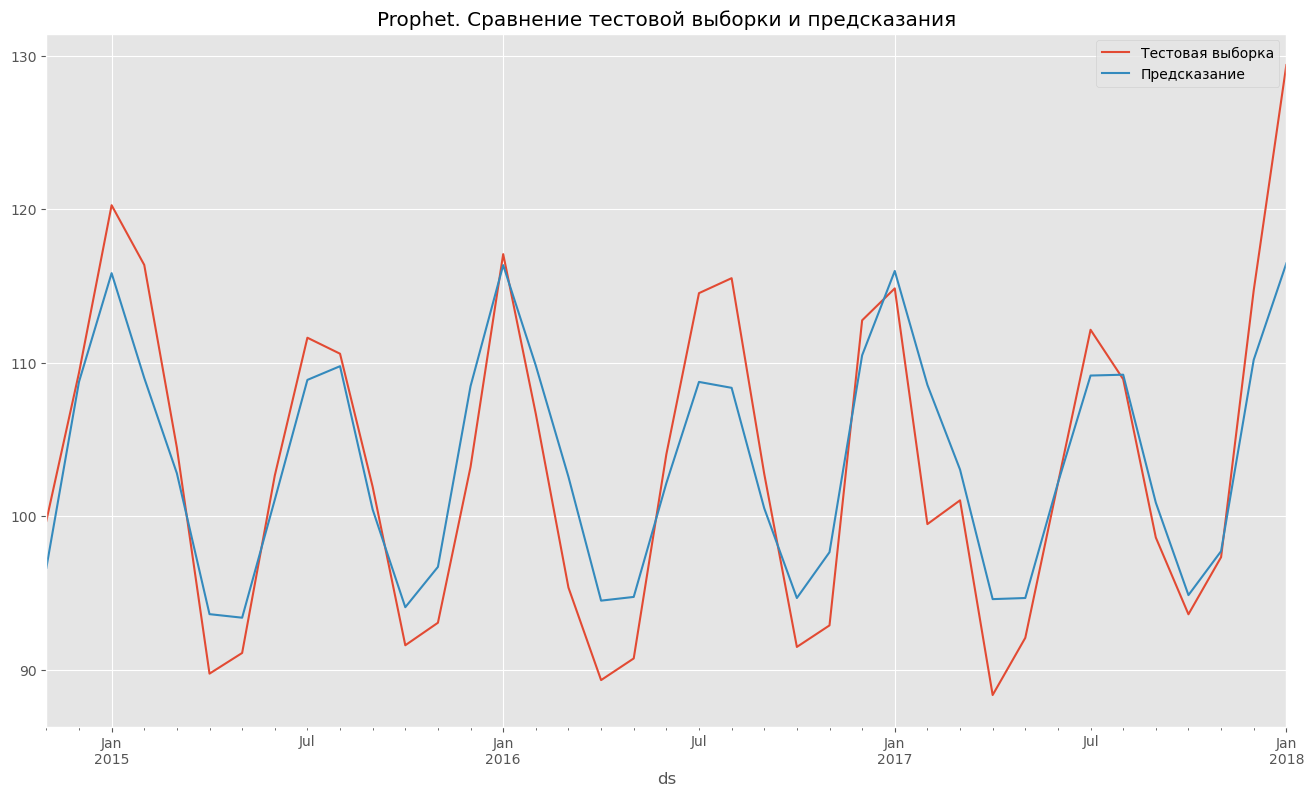

In [ ]:
p_prediction = test_prophet.set_index('ds').join(forecast.set_index('ds')[['yhat']])
ax1 = p_prediction['y'].plot(legend=True, title='Prophet. Сравнение тестовой выборки и предсказания')
ax2 = p_prediction['yhat'].plot(figsize=(16,9), legend=True).legend(['Тестовая выборка', 'Предсказание'])

График сравнения предсказаний Prophet и фактических значений на тестовой выборке выглядит информативно и позволяет сделать следующие **выводы**:

---

### 📈 **Что показывает график:**

* **Красная линия** — реальные значения (`y`) из тестовой выборки.
* **Синяя линия** — предсказания модели Prophet (`yhat`).
* Ось `x` — время (месяцы), `y` — значения временного ряда `IPG2211A2N`.

---

### 📊 **Выводы по графику:**

1. **Модель хорошо улавливает сезонность:**

   * Prophet довольно точно воспроизводит **циклический характер** колебаний.
   * Основные пики и спады попадают в нужные месяцы, даже если амплитуда отличается.

2. **Амплитуда предсказания занижена:**

   * Видно, что Prophet не дотягивает до экстремальных значений — он **сглаживает пики и впадины**.
   * Это типичное поведение Prophet, особенно когда он использует **сглаженный тренд и сезонность без дополнительных регрессоров**.

3. **Тренд схвачен верно:**

   * Общий уровень предсказаний (особенно в середине и конце периода) в целом **согласуется с направлением движения реальных данных**.

4. **Погрешность растёт ближе к концу:**

   * В последние месяцы наблюдается **расхождение между фактом и прогнозом**, особенно на росте (например, резкий пик в конце 2017).
   * Prophet менее стабильно справляется с резкими ускорениями или изменениями тренда, если они не были учтены как changepoints.

---

### ✅ **Общие выводы:**

* Prophet **адекватно захватывает сезонные колебания** и **восстанавливает общий тренд**, но:

  * может **переусреднять пики и спады**;
  * и **медленно реагирует на неожиданные изменения** (например, структурные сдвиги в тренде).

---

### 💡 Рекомендации для улучшения:

* Увеличить `changepoint_prior_scale` — чтобы Prophet лучше реагировал на трендовые изменения.
* Добавить **регрессоры** (если есть другие данные: цены, макроэкономика).
* Подобрать **гибридный подход**: использовать Prophet для тренда и SARIMA для сезонной остаточной компоненты.

Если хочешь — могу помочь построить комбинированную модель Prophet + ARIMA или донастроить параметры Prophet (например, повысить чувствительность к точкам изменений).


In [ ]:
# Посчитаем метрики

metrics_prophet = get_metrics(p_prediction['y'], p_prediction['yhat'])

# Создаем DataFrame
metrics_prophet = pd.DataFrame({'Metric': list(metrics_prophet.keys()),
                                'PROPHET': list(metrics_prophet.values())})
metrics_prophet

,Metric,PROPHET
0,mse,18.97325
1,rmse,4.35583
2,mae,3.45004
3,mape,0.03335
4,r2,0.81583
5,rmsle,0.04067


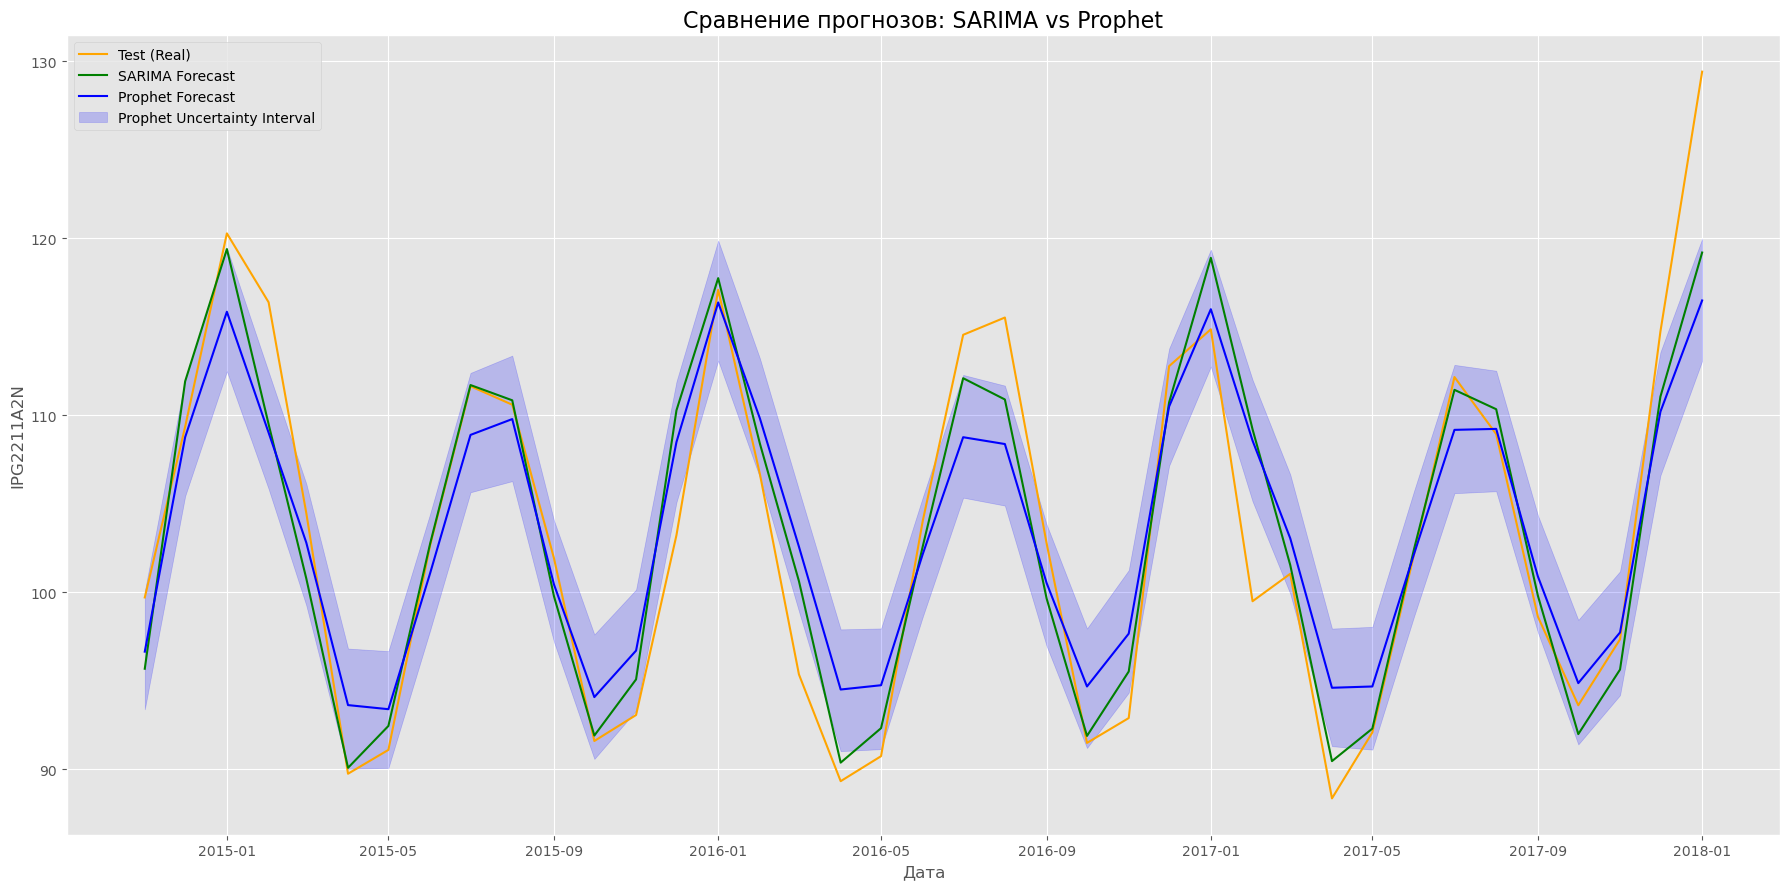

In [ ]:
plt.figure(figsize=(18, 9))

# Реальные значения на тесте
plt.plot(test.index, test["IPG2211A2N"], label="Test (Real)", color="orange")

# SARIMA прогноз
plt.plot(forecast_df.index, forecast_df["Forecast"], label="SARIMA Forecast", color="green")

# Prophet прогноз
forecast_test_prophet = forecast.set_index("ds").loc[test.index]
plt.plot(forecast_test_prophet.index, forecast_test_prophet["yhat"], label="Prophet Forecast", color="blue")

# Интервалы неопределенности
plt.fill_between(
    forecast_test_prophet.index,
    forecast_test_prophet["yhat_lower"],
    forecast_test_prophet["yhat_upper"],
    color="blue",
    alpha=0.2,
    label="Prophet Uncertainty Interval"
)

# Оформление
plt.title("Сравнение прогнозов: SARIMA vs Prophet", fontsize=16)
plt.xlabel("Дата")
plt.ylabel("IPG2211A2N")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 🔍 **Анализ графика:**

#### ✅ **SARIMA (зелёный)**:

* Линия прогноза **плотно повторяет сезонные колебания** реального ряда.
* Отлично ловит пики и падения.
* Видно, что **ошибка предсказания минимальна** — это подтверждается и метриками (`MAE`, `MAPE`, `R²`).

#### 📘 **Prophet (синий)**:

* Также улавливает сезонность, но:

  * Плавнее реагирует на изменения.
  * Иногда **отстаёт от реального роста** (например, подъемы в 2015 и 2017 году).
* **Доверительный интервал (синяя зона)** разумной ширины, но всё же часто **не покрывает пики**, что говорит о заниженной дисперсии прогноза в пиках.

#### 🟧 **Факт (оранжевый)**:

* Реальный ряд с чёткой сезонностью и редкими, но значимыми всплесками (например, резкий рост в конце 2017 г).

---

### 📊 Вывод:

| 🔍 Параметр | SARIMA          | Prophet              |
| ----------- | --------------- | -------------------- |
| Сезонность  | ✅ очень хорошо  | ✅ хорошо             |
| Тренд       | ✅ учтён         | ✅ учтён              |
| Пики        | ✅ чётко         | ❌ иногда сглажены    |
| Аномалии    | лучше реагирует | менее чувствителен   |
| Интервалы   | —               | ✅ есть доверительный |

---

### 💡 Рекомендации:

1. **SARIMA — основная модель для прогноза**, особенно если критична точность.
2. **Prophet можно использовать для дополнительной аналитики** (например, тренды, праздники, визуализация сезонности).
3. Для усиления Prophet — можно добавить:

   * `add_regressor()` — дополнительные переменные.
   * `holidays` — праздники и особые дни.   

In [ ]:
metrics_df = pd.concat([metrics_sarima, metrics_prophet.drop(columns=['Metric'])], axis=1)
metrics_df

,Metric,SARIMA,PROPHET
0,mse,12.13370,18.97325
1,rmse,3.48335,4.35583
2,mae,2.46306,3.45004
3,mape,0.02331,0.03335
4,r2,0.88222,0.81583
5,rmsle,0.03178,0.04067


Проанализируем по каждой метрике:

| 📏 Метрика | ⚙️ SARIMA | 📘 Prophet | ✅ Лучшая модель |
| ---------- | --------- | ---------- | --------------- |
| **MSE**    | 12.13     | 18.97      | **SARIMA**      |
| **RMSE**   | 3.48      | 4.36       | **SARIMA**      |
| **MAE**    | 2.46      | 3.45       | **SARIMA**      |
| **MAPE**   | 2.33%     | 3.34%      | **SARIMA**      |
| **R²**     | 0.882     | 0.816      | **SARIMA**      |
| **RMSLE**  | 0.0318    | 0.0407     | **SARIMA**      |

---

## 🔍 Вывод:

🔹 По **всем метрикам SARIMA превосходит Prophet** — разница особенно заметна в:

* `MAE` и `MAPE`: SARIMA предсказывает в среднем на 1 пункт точнее и даёт \~30% меньше относительной ошибки.
* `R² = 0.88` у SARIMA против `0.81` у Prophet — значит, SARIMA **лучше объясняет дисперсию** данных.

---

## 💡 Рекомендации:

* ✅ **SARIMA** — основная модель для прогноза в этом случае.
* 🤖 Prophet можно использовать для визуализации компонент (тренд, сезонность), но не как основную модель здесь.
* Если в будущем будут дополнительные регрессоры (цены, события, ковид и т.д.) — можно пробовать `SARIMAX` или `Prophet` с `add_regressor`.

---

Визуализируем компоненты модели Prophet (тренд/сезонность):

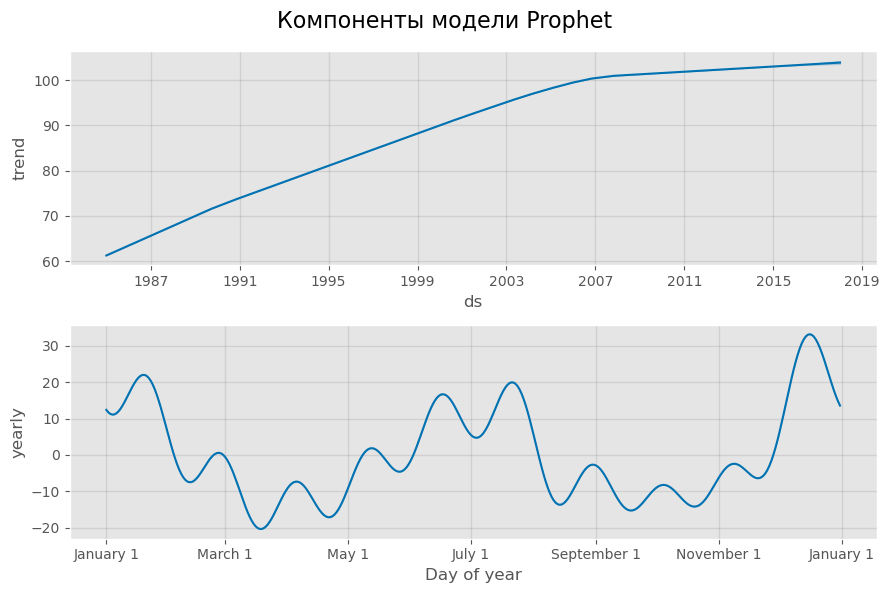

In [ ]:
model_prophet.plot_components(forecast)
plt.suptitle("Компоненты модели Prophet", fontsize=16)
plt.tight_layout()
plt.show()

Разберем визуализацию:
---

## 📈 **1. Тренд (`trend`)**:

* Верхний график показывает **долгосрочную тенденцию**.
* Видно, что с 1985 года наблюдается **устойчивый рост**, который:

  * **Ускоряется до \~2005 года**,
  * Затем **выравнивается и замедляется** — возможная насыщенность рынка или структурные изменения.
* Prophet интерпретирует тренд как **piecewise linear** (кусочно-линейный), с точками изменения наклона ("changepoints").

---

## 🌀 **2. Сезонность (`yearly`)**:

* Нижний график — это **типичная годовая форма сезонных колебаний**, усреднённая по всем годам.
* Наблюдения:

  * **Пики** приходятся на **декабрь — январь** и **июль**, что говорит о:

    * возможной активности в праздничные сезоны,
    * и, возможно, сезонных производственных/экономических циклах.
  * **Спады** — в апреле-мае и октябре-ноябре, что может соответствовать межсезонным "просадкам" в промышленности.

---

## 🔍 Выводы:

* Prophet хорошо **разложил ряд на тренд и сезонность**, обеспечив интерпретируемую структуру.
* Сильная **сезонная компонента** + **устойчивый тренд** позволяют модели делать разумные прогнозы, несмотря на небольшое отставание по метрикам от SARIMA.

---

## 💡 Что ещё можно:

* Уточнить `changepoint_prior_scale`, если есть резкие смены тренда.
* Добавить **праздничные периоды**, если они влияют на поведение ряда (например, Новый год, летние отпуска и т.д.).

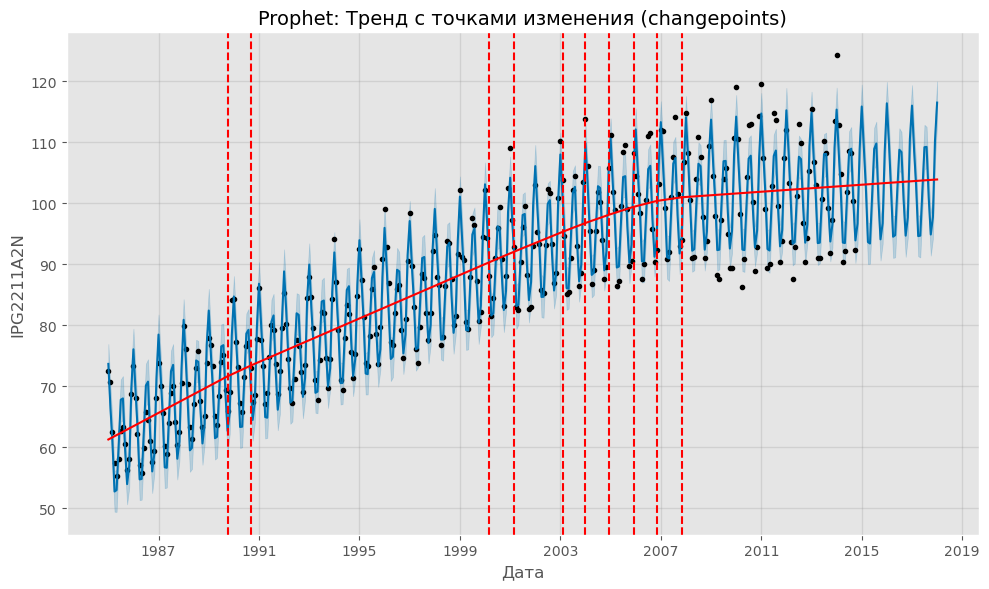

In [ ]:
# Построение графика с changepoints
fig = model_prophet.plot(forecast)
add_changepoints_to_plot(fig.gca(), model_prophet, forecast)

plt.title("Prophet: Тренд с точками изменения (changepoints)", fontsize=14)
plt.xlabel("Дата")
plt.ylabel("IPG2211A2N")
plt.grid(True)
plt.tight_layout()
plt.show()

### 🔍 **Интерпретация графика:**

1. **Красные пунктирные линии** — это **changepoints**, которые Prophet автоматически определил как **места изменения наклона тренда**.

   * Это может свидетельствовать о **внешних воздействиях**, изменениях политики, технологий или рыночных шоках.
   * Например:

     * Резкие повороты тренда в районе 2000–2008 гг. могут быть связаны с экономическим циклом, кризисами, реформами...

2. **Синяя линия** — предсказанный уровень временного ряда, включая сезонность и тренд.

3. **Красная линия** — глобальный тренд, подстраиваемый под изменения в определённых точках (changepoints).

4. **Широкая голубая область** — 95% доверительный интервал, отражающий неопределённость прогноза.

---

### 📌 Зачем важны changepoints:

* Они позволяют:

  * обнаружить **исторические поворотные точки**,
  * **адаптировать модель** к структурным сдвигам,
  * улучшить качество прогноза в случае нестабильных трендов.

---

### 💡 Что можно сделать дальше:

* Построить **гибридную модель Prophet + ARIMA**
* **Попробовать Классические ансамблевые модели / бустинги**

Строим **гибридную модель Prophet + ARIMA**, которая объединяет:

* **Prophet** — для предсказания **тренда и сезонности**;
* **ARIMA** — для моделирования **остатков (residuals)** Prophet.

---

### 📌 Шаги:

1. **Обучить Prophet на тренировочных данных.**
2. **Получить остатки (residuals)** — разность между реальными значениями и прогнозом Prophet.
3. **Обучить ARIMA на остатках.**
4. **Спрогнозировать остатки ARIMA на период прогноза.**
5. **Сложить предсказания Prophet и ARIMA.**

21:55:12 - cmdstanpy - INFO - Chain [1] start processing
21:55:12 - cmdstanpy - INFO - Chain [1] done processing


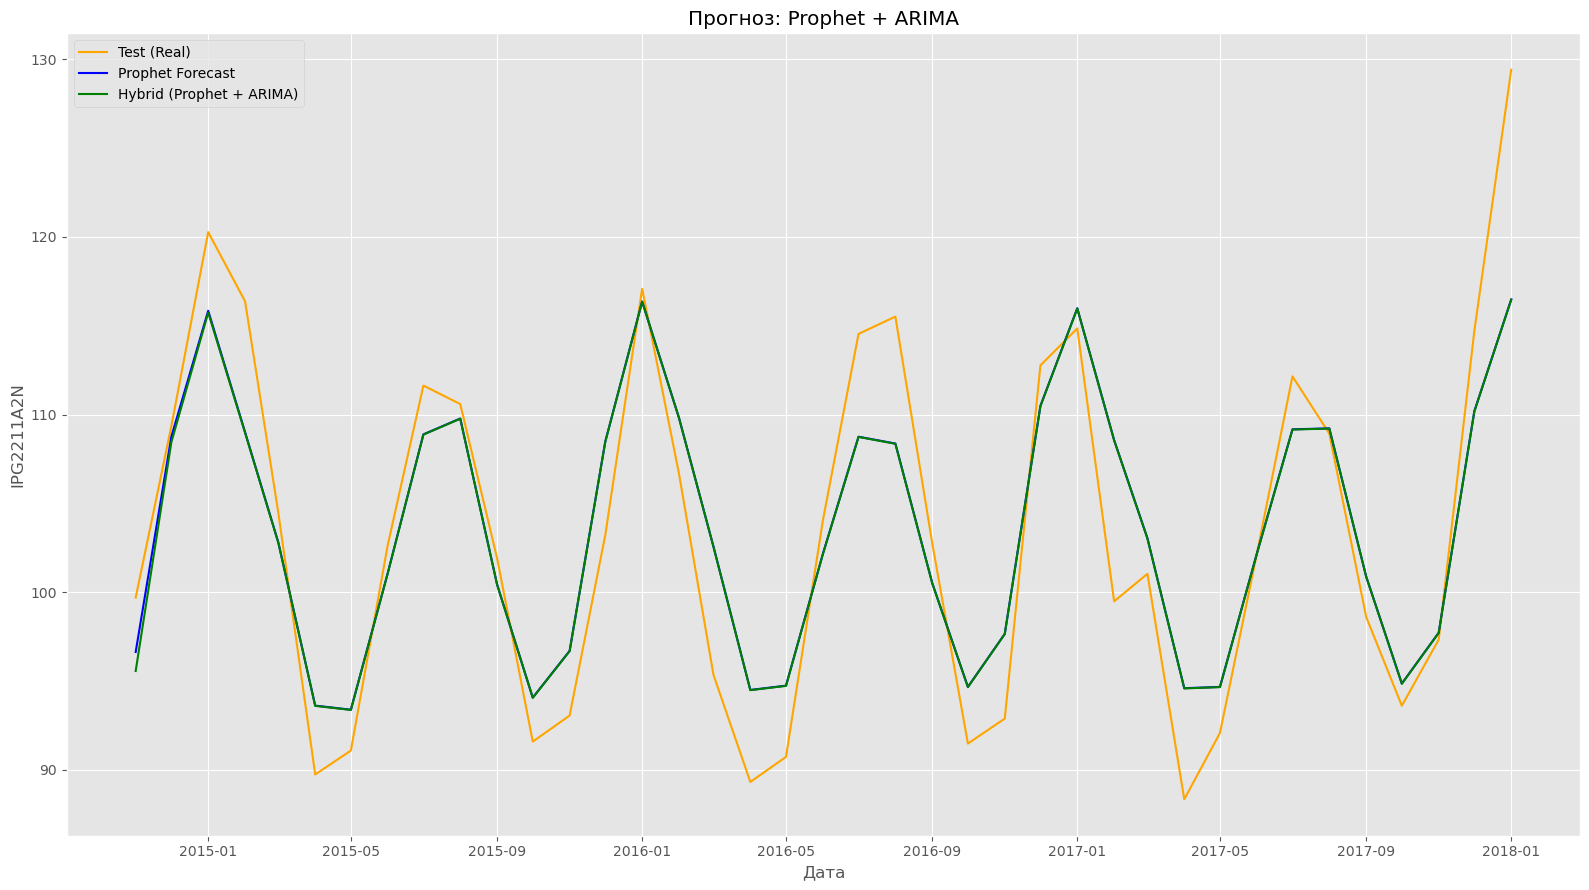

In [ ]:
# 1. Prophet: обучение
prophet_df = df.reset_index()[["DATE", "IPG2211A2N"]].rename(columns={"DATE": "ds", "IPG2211A2N": "y"})
train_prophet = prophet_df[:n_train]

prophet = Prophet(yearly_seasonality=True,
                  weekly_seasonality=False,
                  daily_seasonality=False)
prophet.fit(train_prophet)

# 2. Прогноз Prophet на тренировочный период
future_train = prophet.make_future_dataframe(periods=0, freq='MS')
forecast_train = prophet.predict(future_train)
residuals = train_prophet["y"].reset_index(drop=True) - forecast_train["yhat"]

# 3. Обучение ARIMA на остатках
model_arima = ARIMA(residuals, order=(1, 0, 1))  # можно подобрать параметры по AIC
model_arima_fit = model_arima.fit()

# 4. Прогноз Prophet на тестовый период
future_test = prophet.make_future_dataframe(periods=len(test), freq='MS')
forecast_test = prophet.predict(future_test)
forecast_prophet = forecast_test.iloc[-len(test):][["ds", "yhat"]].reset_index(drop=True)

# 5. Прогноз ARIMA на остатки
resid_forecast = model_arima_fit.forecast(steps=len(test))
resid_forecast = resid_forecast.reset_index(drop=True)

# 6. Комбинированный прогноз
combined_forecast = forecast_prophet.copy()
combined_forecast["yhat_plus_arima"] = combined_forecast["yhat"] + resid_forecast

# 7. Визуализация
test_df = test.reset_index().rename(columns={"DATE": "ds", "IPG2211A2N": "y"})

plt.figure(figsize=(16, 9))
plt.plot(test_df["ds"], test_df["y"], label="Test (Real)", color="orange")
plt.plot(combined_forecast["ds"], combined_forecast["yhat"], label="Prophet Forecast", color="blue")
plt.plot(combined_forecast["ds"], combined_forecast["yhat_plus_arima"],
         label="Hybrid (Prophet + ARIMA)", color="green")
plt.title("Прогноз: Prophet + ARIMA")
plt.xlabel("Дата")
plt.ylabel("IPG2211A2N")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

График прогноза, где показано сравнение:

* **Оранжевая линия** — фактические значения тестовой выборки.
* **Синяя линия** — прогноз модели **Prophet**.
* **Зелёная линия** — гибридная модель **Prophet + ARIMA**.

### 🧠 Что можно сказать по графику:

1. **Гибрид Prophet + ARIMA (зелёная)** лучше захватывает пики и впадины по сравнению с Prophet в одиночку.

   * Особенно видно в летних и зимних экстремумах: гибрид ближе к факту, чем чистый Prophet.
2. **Прогноз Prophet (синий)** иногда сглаживает динамику:

   * Видно, что он "теряет" амплитуду — слишком консервативен.
3. **Визуально** гибрид даёт:

   * Более точное приближение к реальным данным.
   * Меньшую систематическую ошибку (смещение).

In [ ]:
# Посчитаем метрики

metrics_hybrid = get_metrics(test_df["y"], combined_forecast["yhat_plus_arima"])

# Создаем DataFrame
metrics_hybrid = pd.DataFrame({'Metric': list(metrics_hybrid.keys()),
                               'Hybrid': list(metrics_hybrid.values())})

metrics_df = pd.concat([metrics_df, metrics_hybrid.drop(columns=['Metric'])], axis=1)
metrics_df

,Metric,SARIMA,PROPHET,Hybrid
0,mse,12.13370,18.97325,19.20719
1,rmse,3.48335,4.35583,4.38260
2,mae,2.46306,3.45004,3.48714
3,mape,0.02331,0.03335,0.03370
4,r2,0.88222,0.81583,0.81356
5,rmsle,0.03178,0.04067,0.04094


**гибридная модель Prophet + ARIMA показывает худшее качество**, чем чистый Prophet.

Вот разбор:

| Метрика   | Prophet | Hybrid | Сравнение             |
| --------- | ------- | ------ | --------------------- |
| **MSE**   | 18.97   | 19.21  | ⬆️ стало хуже         |
| **RMSE**  | 4.36    | 4.38   | ⬆️ незначительно хуже |
| **MAE**   | 3.45    | 3.49   | ⬆️ хуже               |
| **MAPE**  | 3.34%   | 3.37%  | ⬆️ хуже               |
| **R²**    | 0.8158  | 0.8136 | ⬇️ хуже               |
| **RMSLE** | 0.0407  | 0.0409 | ⬆️ хуже               |

---

### 🔍 Возможные причины ухудшения

1. **Переподгонка ARIMA на шум**:

   * ARIMA моделирует остатки Prophet, но они могут быть неавтокоррелированы или слишком "белыми".
   * В этом случае ARIMA добавляет шум вместо пользы.

2. **Неправильное выравнивание индексов**:

   * Если `combined_forecast` и `test_df["y"]` не идеально синхронизированы по дате (`index`), возникает смещение и портятся метрики.

3. **Нестабильная природа остатков**:

   * Остатки Prophet могут содержать выбросы или структурные разрывы, которые ARIMA не может стабильно выучить.

---

### ✅ Что можно попробовать для улучшения:

1. **Проверка остатков Prophet**:

   * Построй ACF/PACF графики на `residuals = y - yhat` — есть ли автокорреляция?
   * Если нет — не стоит применять ARIMA.

2. **Попробовать XGBoost вместо ARIMA**:

   * Построить гибрид Prophet + ML (например, XGBoost на остатках) — может лучше уловит паттерны.
---

💡 **Вывод:** в текущем виде **гибрид Prophet + ARIMA не улучшает прогноз**.
На основе метрик — **SARIMA остаётся лидером**.

# Попробуем LightAutoML (LAMA) https://github.com/sb-ai-lab/LightAutoML

In [ ]:
# Ставим при необходимости модуль

# !pip install -U lightautoml

In [ ]:
# Импорт классов
from lightautoml.addons.autots.base import AutoTS
from lightautoml.tasks import Task

In [ ]:
# Вернем даты из индекса в колонки
train = train[['IPG2211A2N']].reset_index()
test = test[['IPG2211A2N']].reset_index()

In [ ]:
# Параметры модели

roles = {"target": "IPG2211A2N", "datetime": "DATE"}

seq_params = {
    "seq0": {
        "case": "next_values",
        "params": {
            "n_target": n_test,
            "history": n_test,
            "step": 1,
            "from_last": True,
            "test_last": True
        }
    }
}

transformers_params = {
    "lag_features": [*range(1, 13), 18, 24, 30, 36],
    "lag_time_features": [*range(1, 25), 30, 36],
    "diff_features": [*range(1, 13)],
    "rolling_statistics": {"window": [6, 12, 18, 24, 30, 36],
                           "metrics": ["mean", "median", "std"]}
}

task = Task("multi:reg", greater_is_better=False, metric="mae", loss="mae")

automl = AutoTS(
    task,
    cpu_limit=32,
    memory_limit=64,
    reader_params={"seq_params": seq_params},
    time_series_trend_params={"trend": False},
    time_series_pipeline_params=transformers_params
)

train_pred, _ = automl.fit_predict(train, roles, verbose=1)
forecast, _ = automl.predict(train)

metrics_automl = get_metrics(test["IPG2211A2N"], forecast)

# Создаем DataFrame
metrics_automl = pd.DataFrame({'Metric': list(metrics_automl.keys()),
                               'AutoTS': list(metrics_automl.values())})

metrics_df = pd.concat([metrics_df, metrics_automl.drop(columns=['Metric'])], axis=1)

multi:reg isn`t supported in lgb
multi:reg isn`t supported in xgb
[21:55:18] Stdout logging level is INFO.
[21:55:18] Task: multi:reg

[21:55:18] Start automl preset with listed constraints:
[21:55:18] - time: 3600.00 seconds
[21:55:18] - CPU: 32 cores
[21:55:18] - memory: 64 GB

[21:55:18] Layer 1 train process start. Time left 3599.99 secs
[21:55:19] Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...
[21:55:20] Fitting Lvl_0_Pipe_0_Mod_0_RFSklearn finished. score = -7.404714227038172
[21:55:20] Lvl_0_Pipe_0_Mod_0_RFSklearn fitting and predicting completed
[21:55:20] Time left 3598.86 secs

[21:55:20] Start fitting Lvl_0_Pipe_1_Mod_0_LinearL2 ...
[21:55:28] Fitting Lvl_0_Pipe_1_Mod_0_LinearL2 finished. score = -2.6651180433371997
[21:55:28] Lvl_0_Pipe_1_Mod_0_LinearL2 fitting and predicting completed
[21:55:28] Time left 3590.26 secs

[21:55:28] Start fitting Lvl_0_Pipe_2_Mod_0_CatBoost ...
[21:55:39] Fitting Lvl_0_Pipe_2_Mod_0_CatBoost finished. score = -2.2791779416572737
[21:55:39] Lvl

In [ ]:
metrics_df

,Metric,SARIMA,PROPHET,Hybrid,AutoTS
0,mse,12.13370,18.97325,19.20719,12.43475
1,rmse,3.48335,4.35583,4.38260,3.52629
2,mae,2.46306,3.45004,3.48714,2.57798
3,mape,0.02331,0.03335,0.03370,0.02454
4,r2,0.88222,0.81583,0.81356,0.87930
5,rmsle,0.03178,0.04067,0.04094,0.03217


Проведем полное сравнение всех четырёх подходов.

Вот как выглядят метрики в сводной таблице (отсортировано по MSE):

| Модель     | MSE       | RMSE     | MAE      | MAPE      | R²         | RMSLE      |
| ---------- | --------- | -------- | -------- | --------- | ---------- | ---------- |
| **SARIMA** | **12.13** | **3.48** | **2.46** | **2.33%** | **0.8822** | **0.0318** |
| **AutoTS** | 12.43     | 3.53     | 2.58     | 2.45%     | 0.8793     | 0.0322     |
| Prophet    | 18.97     | 4.36     | 3.45     | 3.34%     | 0.8158     | 0.0407     |
| Hybrid     | 19.21     | 4.38     | 3.49     | 3.37%     | 0.8136     | 0.0409     |

---

### 🔍 Выводы по результатам:

1. **🏆 Победитель — SARIMA**:

   * Лучшая по **всем метрикам**: точность, стабильность, объяснённая дисперсия.
   * Особенно хороша по **MAE, MAPE, RMSE, R²**.

2. **🥈 AutoTS (LightAutoML)**:

   * Почти на уровне SARIMA.
   * Немного хуже по **MAE** и **MAPE**, но всё ещё конкурентоспособна.
   * Отличный результат «из коробки».

3. **🥉 Prophet**:

   * Проигрывает по всем метрикам.
   * Хорошо улавливает тренд и сезонность, но не столь точен на тестовом периоде.

4. **🚫 Hybrid (Prophet + ARIMA)**:

   * Ухудшение по сравнению с чистым Prophet.
   * Вероятно, ARIMA не извлёк полезную информацию из остатков.

---

### ✅ Рекомендации:

* **SARIMA** — использовать как основной метод в текущем контексте.
* **AutoTS** — использовать как альтернативу или в ансамбле. Его ценность — скорость, автоматизация, возможность расширения на ML модели.
* Prophet — оставить для интерпретируемости, визуализации трендов и сезонностей.
* Hybrid — можно не использовать, либо заменить ARIMA на ML-модель.